# Maps

inspired by 

https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0 

https://gisco-services.ec.europa.eu/distribution/v2/countries/

https://pypi.org/project/pyshp/

https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f


In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline


# load shapefile .shp

In [4]:
shp_path = r"./maps/EU_SHP/CNTR_RG_20M_2020_3035.shp" 
sf = shp.Reader(shp_path)
shapeRecs = sf.shapeRecords()

df_shapes = pd.DataFrame(columns = ['country_code', 'shape'])


an example of border and colorfill
NOTE: a country may be composed of one or MORE shapes

adding to df_shapes 0
adding to df_shapes 1


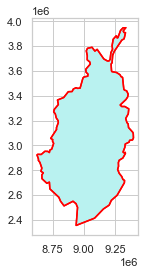

In [8]:

country_id = 1
fillcolor = "c"
bordercolor = "red"
df_shapes = pd.DataFrame(columns = ['country_code', 'shape'])

country_shape = shapeRecs[country_id].shape
idx = []
idx = country_shape.parts
n_parts = len(idx)
n_points = len(country_shape.points)
idx.append(n_points)

plt.figure()
ax = plt.axes()
ax.set_aspect('equal')
for i in range(n_parts): #a country may be composed of several shapes
    p0 = idx[i]
    p1 = idx[i+1]
    if (p1-p0)>10:  #avoid small shapes
        shape_ex = sf.shape(country_id)
        seg=shape_ex.points[p0:p1]
        x_lon = np.zeros((len(seg),1))
        y_lat = np.zeros((len(seg),1))
        nn = len(seg) if i < n_parts else 0
        for ip in range(nn):
            x_lon[ip] = seg[ip][0]
            y_lat[ip] = seg[ip][1]
    plt.plot(x_lon,y_lat, c = bordercolor) 
    plt.fill(x_lon,y_lat, fillcolor)
    
    print("adding to df_shapes", i)
    tmp= [(x_lon[i][0], y_lat[i][0]) for i in range(0, len(x_lon))]
    new_row = {'country_code': 'IT', 'shape': tmp}
    df_shapes = df_shapes.append(new_row, ignore_index = True)

use country names as ISO codes



In [13]:
data = pd.read_excel("./maps/EU_ISO_CODES.xlsx",sheet_name ="data",   usecols = "A:B")
xmin = min(data.x)
xmax = max(data.x)
xnorm = (data.x-xmin)/(xmax-xmin)


<function matplotlib.pyplot.show(close=None, block=None)>

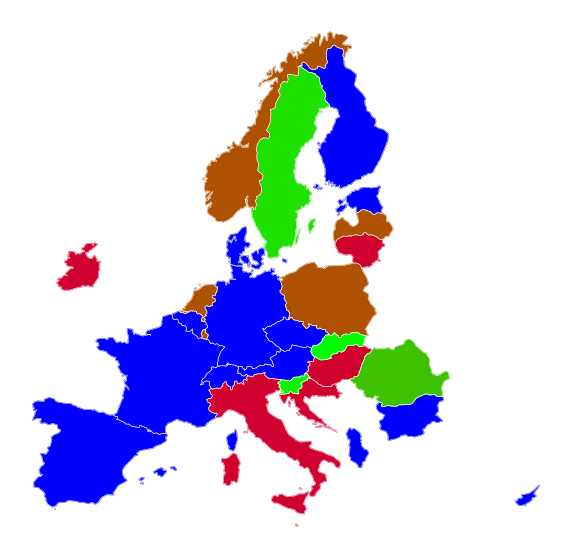

In [14]:

n_shapes = len(shapeRecs)
eunames = ['AL','AT','BE','BG','HR','CH','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','NO','PL','RO','SK','SI','ES','SE', 'GB']
#eunames = ['AT','IT','SI']
#eunames = ['IT', 'FR', 'ES']

fillcolor = "blue"
bordercolor = "white"

x = data

cmap = plt.get_cmap('brg')
colors = cmap(xnorm)
x_min, x_max = 22E5, 70E5

plt.figure(figsize = (10,10))
#ax = plt.axes()
ax.set_aspect('equal')
df_shapes = pd.DataFrame(columns = ['country_code', 'shape'])

for sh_id in range(n_shapes):
    country_code = shapeRecs[sh_id].record[0]
    if country_code in eunames:
        val = min(data[ data['ISO2'] == country_code ].x)
        country_shape = shapeRecs[sh_id].shape
        idx = []
        idx = country_shape.parts
        n_parts = len(idx)
        n_points = len(country_shape.points)
        idx.append(n_points)

        for i in range(n_parts): #a country may be composed of several shapes
            p0 = idx[i]
            p1 = idx[i+1]
            if (p1-p0)>6:  #avoid small shapes
                shape_ex = sf.shape(sh_id)
                seg=shape_ex.points[p0:p1]
                x_lon = np.zeros((len(seg),1))
                y_lat = np.zeros((len(seg),1))
                nn = len(seg) if i < n_parts else 0
                for ip in range(nn):
                    x_lon[ip] = seg[ip][0]
                    y_lat[ip] = seg[ip][1]
                    
                if (min(x_lon[0]) > x_min) & (max(x_lon[0]) < x_max):
                    fillcolor = (val-xmin)/(xmax-xmin)
                    plt.plot(x_lon,y_lat, c = bordercolor, linewidth =.5, alpha = 1) 
                    plt.fill(x_lon,y_lat, color = cmap(fillcolor), alpha = 1)
                    
                    #print("adding to df_shapes", i)
                    tmp= [(x_lon[i][0], y_lat[i][0]) for i in range(0, len(x_lon))]
                    new_row = {'country_code': country_code, 'shape': tmp}
                    df_shapes = df_shapes.append(new_row, ignore_index = True)
plt.grid(False)
plt.axis('off')
plt.show



# Read shapefile and write shapes to a csv ready for dataframe


In [21]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    #remove unwanted characters in column names
    cols =  [ 'CNTR_NAME', 'NAME_ENGL', 'ISO3_CODE', 'FID']
    for col in cols:
        df_coords[col] = df_coords[col].apply(lambda x: x.replace("\x00", ""))
    return df






In [23]:
df_coords = read_shapefile(sf)
df_coords.head(3)


,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,coords
0,AE,الإمارات العربية المتحدة                      ...,United Arab Emirates                        ,ARE,AE,"[(8837659.050700001, 1611402.7382999994), (882..."
1,AF,افغانستان-افغانستان                           ...,Afghanistan                                 ,AFG,AF,"[(9337416.930300001, 3947645.3164), (9317737.4..."
2,AG,Antigua and Barbuda                           ...,Antigua and Barbuda                         ,ATG,AG,"[(-2522850.5996, 2842090.8299), (-2528775.4118..."


In [24]:
df_coords.to_csv('./maps/world_shapes.csv', index = False)

In [43]:
selected_countries = ['ITA','FRA','AUT']
df_coords = read_shapefile(sf)
df_coords = df_coords[df_coords['ISO3_CODE'].isin(selected_countries)  ]
df_coords.head(3)


,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,coords
9,AT,Österreich                                    ...,Austria                                     ,AUT,AT,"[(4832035.2254, 2857836.831599999), (4833565.8..."
94,FR,France                                        ...,France                                      ,FRA,FR,"[(9954236.1162, -3059379.3164), (9961022.5883,..."
99,IT,Italia                                        ...,Italy                                       ,ITA,IT,"[(4606152.070499999, 2608175.0654), (4604291.0..."


In [44]:
df_coords.to_csv('./maps/selected_countries.csv', index = False)
